# YOLOv5 FSOCO Training

**Essential steps only:**
1. Setup YOLOv5
2. Convert FSOCO labels (Supervisely YOLO)
3. Train
4. Inference

run this to include the yolov5 folder
`git submodule update --init --recursive`
**Run from:** `driverless-ml-dev/perceptions/camera-pipeline/notebooks/`

**Activate venv in root/driverless-ml-dev directory, and connect kernel for this notebook to it**
open vsc terminal via ctrl+shift+`

first time only:
```
cd ~/driverless-ml-dev
python -m venv venv
source venv/bin/activate
pip install ipykernel
python -m ipykernel install --name driverless-ml --display-name "Python (driverless-ml)" --user
```
then type `>developer reload` in the search bar at the top

to activate venv
```
cd /root/driverless-ml-dev
source venv/bin/activate
```
then type `>developer reload` in the search bar at the top

install libraries with: `pip install pillow tqdm pyyaml`

In [1]:
# %cd ~/driverless-ml-dev
# !python -m venv venv
# !source venv/bin/activate
# !venv/bin/python -m pip install --upgrade pip ipykernel
# !venv/bin/python -m ipykernel install --name driverless-ml --display-name "Python (driverless-ml)" --user

**Activate venv in root/driverless-ml-dev directory, and connect kernel for this notebook to it**

## 1. Setup

In [2]:

import os
import sys
from pathlib import Path

# Paths
ROOT = Path.cwd().parent.parent.parent  # driverless-ml-dev/
print(ROOT)
YOLO_DIR = ROOT / 'yolov5'
DATA_DIR = ROOT / 'ml_data'
FSOCO_RAW = ROOT / 'ml_data/perceptions/fsoco_raw'  # Download FSOCO here
FSOCO_YOLO = ROOT / 'ml_data/perceptions/fsoco_yolo'  # Converted dataset
FSOCO_MOD = ROOT / 'ml_data/perceptions/fsoco_mod'  # Working copy for preprocessing

print(f"Root: {ROOT}")
print(f"YOLOv5: {YOLO_DIR}")
print(f"Data: {DATA_DIR}")
print(f"Fsoco_raw: {FSOCO_RAW}")
print(f"Fsoco_mod: {FSOCO_MOD}")
print(f"Fsoco_yolo: {FSOCO_YOLO}")
# for item in FSOCO_MOD.iterdir():
    # print(f"  - {item.name}")

/root/driverless-ml-dev
Root: /root/driverless-ml-dev
YOLOv5: /root/driverless-ml-dev/yolov5
Data: /root/driverless-ml-dev/ml_data
Fsoco_raw: /root/driverless-ml-dev/ml_data/perceptions/fsoco_raw
Fsoco_mod: /root/driverless-ml-dev/ml_data/perceptions/fsoco_mod
Fsoco_yolo: /root/driverless-ml-dev/ml_data/perceptions/fsoco_yolo


In [ ]:
# Clone YOLOv5
if not YOLO_DIR.exists() and not any(YOLO_DIR.iterdir()):
    !cd {ROOT} && git clone https://github.com/ultralytics/yolov5.git
    print("YOLOv5 cloned")
else:
    print("YOLOv5 exists")

# Install requirements
%pip install -r {YOLO_DIR}/requirements.txt
print("Dependencies installed")

✓ YOLOv5 exists


Note: you may need to restart the kernel to use updated packages.
✓ Dependencies installed


## 2. Download FSOCO Dataset

**Manual step required:**
1. Visit: https://fsoco.github.io/fsoco-dataset/download
2. Download Bounding Boxes dataset (24GB)
3. Extract to: `root/ml-data/perceptions/`

Expected structure:
```
root/ml-data/perceptions/
└── fsoco_raw/
    ├── team1/ann/       # JSON annotations
    ├── team1/img/       # Images
    └── meta.json
```

In [ ]:
import os
import shutil
from pathlib import Path

def copy_and_flatten_dataset(source_path: Path, dest_path: Path):
    """
    Copy + flatten in one pass:
    source/
      - meta.json
      - teamA/{ann,img}
      - teamB/{ann,img}
      ...
    ->
    dest/
      - ann/
      - img/
      - meta.json
    Files in dest/ann and dest/img are prefixed with the team folder name.
    """
    if not source_path.exists() or not any(source_path.iterdir()):
        raise FileNotFoundError(f"Source dataset not found or empty: {source_path}")

    # Skip the heavy copy if the destination already contains data
    if dest_path.exists() and any(dest_path.iterdir()):
        print(f"Skipping copy: destination already populated {dest_path}")
        return

    # Ensure destination exists
    dest_path.mkdir(parents=True, exist_ok=True)

    # Start clean: remove all existing contents in the destination
    for item in dest_path.iterdir():
        if item.is_dir():
            shutil.rmtree(item)
        else:
            item.unlink()

    ann_out = dest_path / "ann"
    img_out = dest_path / "img"
    ann_out.mkdir(exist_ok=True)
    img_out.mkdir(exist_ok=True)

    # Copy meta.json if present
    meta_src = source_path / "meta.json"
    if meta_src.exists():
        shutil.copy2(meta_src, dest_path / "meta.json")

    ann_count = 0
    img_count = 0

    # Walk team directories in source and copy directly into flattened outputs
    for team_dir in source_path.iterdir():
        print(f"Processing team directory: {team_dir.name}")
        if not team_dir.is_dir():
            print(f"Skipping non-directory item: {team_dir.name}")
            continue  # skip files at root (handled meta.json above)

        if team_dir.name in {"ann", "img"}:
            continue  # guard in case the source is already partially flattened

        ann_dir = team_dir / "ann"
        img_dir = team_dir / "img"

        if ann_dir.exists():
            for f in ann_dir.iterdir():
                if f.is_file():
                    dest = ann_out / f"{team_dir.name}_{f.name}"
                    shutil.copy2(f, dest)
                    ann_count += 1

        if img_dir.exists():
            for f in img_dir.iterdir():
                if f.is_file():
                    dest = img_out / f"{team_dir.name}_{f.name}"
                    shutil.copy2(f, dest)
                    img_count += 1

    print(f"Copy+flatten complete {ann_out} ({ann_count} files), {img_out} ({img_count} files)")

# --- Usage with your existing variables ---
# Assumes FSOCO_RAW and FSOCO_MOD are Path objects defined elsewhere
raw_exists = FSOCO_RAW.exists()

os.path.isdir(FSOCO_RAW)
raw_has_content = os.path.isdir(FSOCO_RAW) if raw_exists else False
print(os.path.isdir(FSOCO_RAW) if raw_exists else False)
print(FSOCO_RAW)
print(raw_exists)
print(raw_has_content)

#used later on to skip ratio filtering since it assumes you already ran it
mod_exists = FSOCO_MOD.exists()
if raw_exists and raw_has_content:
    print("FSOCO dataset found")
    if FSOCO_MOD.exists() and any(FSOCO_MOD.iterdir()):
        print(f"Skipping flatten: working copy already populated {FSOCO_MOD}")
    else:
        for item in FSOCO_RAW.iterdir():
            print(f"  - {item.name}")
        FSOCO_MOD.mkdir(parents=True, exist_ok=True)
        copy_and_flatten_dataset(FSOCO_RAW, FSOCO_MOD)
else:
    raise FileNotFoundError(f"Download FSOCO dataset to: {FSOCO_RAW}")


True
/root/driverless-ml-dev/ml_data/perceptions/fsoco_raw
True
True
✓ FSOCO dataset found
✓ Skipping flatten: working copy already populated → /root/driverless-ml-dev/ml_data/perceptions/fsoco_mod


In [ ]:
# Check structure
if not FSOCO_MOD.exists():
    raise FileNotFoundError(
        f"Working dataset directory not found: {FSOCO_MOD}. Run the preparation step and ensure the directory exists."
    )

if not any(FSOCO_MOD.iterdir()):
    raise RuntimeError(
        f"Working dataset directory is empty: {FSOCO_MOD}. Run the preparation step to copy data before proceeding."
    )

working_dataset = FSOCO_MOD
print(f"Inspecting dataset at: {working_dataset}")

bb_path = working_dataset / 'ann'
print(bb_path)
print("ann contents:")
if bb_path.exists():
    items = list(os.listdir(bb_path))[:5]
    for item in items:
        print(f"  {item}")
else:
    print("no ann directory found")

img_path = working_dataset / 'img'

print("\nimg contents:")
if img_path.exists():
    items = list(os.listdir(img_path))[:5]
    for item in items:
        print(f"  {item}")
else:
    print("no image directory found")

print("\nmeta.json:")
meta_path = working_dataset / 'meta.json'

if meta_path.exists():
    import json
    meta = json.load(open(meta_path))
    print(json.dumps(meta, indent=2)[:500])
else:
    print("meta.json not found")

Inspecting dataset at: /root/driverless-ml-dev/ml_data/perceptions/fsoco_mod
/root/driverless-ml-dev/ml_data/perceptions/fsoco_mod/ann
ann contents:
  amz_amz_00000.jpg.json
  amz_amz_00001.jpg.json
  amz_amz_00002.jpg.json
  amz_amz_00003.jpg.json
  amz_amz_00004.jpg.json

img contents:


  amz_amz_00000.jpg
  amz_amz_00001.jpg
  amz_amz_00002.jpg
  amz_amz_00003.jpg
  amz_amz_00004.jpg

meta.json:
{
  "classes": [
    {
      "title": "seg_orange_cone",
      "shape": "bitmap",
      "color": "#FF8000",
      "geometry_config": {},
      "id": 9993505,
      "hotkey": ""
    },
    {
      "title": "unknown_cone",
      "shape": "rectangle",
      "color": "#3BDB0F",
      "geometry_config": {},
      "id": 9993514,
      "hotkey": ""
    },
    {
      "title": "yellow_cone",
      "shape": "rectangle",
      "color": "#FFFF00",
      "geometry_config": {},
      "id": 9993506,
      "ho


## 3. Filter Images by Aspect Ratio

Remove images that don't meet minimum aspect ratio requirements (width/height).

In [ ]:
from PIL import Image
import os
from tqdm import tqdm
from collections import Counter

def filter_images_by_aspect_ratio(fsoco_mod, min_ratio=1.0, max_ratio=3.0):
    """
    Filter out images that don't meet aspect ratio requirements.
    
    Args:
        fsoco_mod: Path to FSOCO dataset
        min_ratio: Minimum aspect ratio (width/height)
        max_ratio: Maximum aspect ratio (width/height)
    
    Returns:
        List of filtered image paths and count of removed images
    """
    img_dir = fsoco_mod / 'images'
    if not img_dir.exists():
        img_dir = fsoco_mod / 'img'
    ann_dir = fsoco_mod / 'bounding_boxes'
    if not ann_dir.exists():
        ann_dir = fsoco_mod / 'ann'
    
    if not img_dir.exists():
        print(f"Image directory not found: {img_dir}")
        return [], 0
    
    images = list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png'))
    print(f"Total images found: {len(images)}")
    
    filtered_images = []
    removed_images = []
    kept_dimensions = []
    removed_dimensions = []
    kept_aspect_ratios = []
    removed_aspect_ratios = []
    
    for img_path in tqdm(images, desc="Filtering images by aspect ratio"):
        try:
            img = Image.open(img_path)
            w, h = img.size
            aspect_ratio = w / h
            
            if min_ratio <= aspect_ratio <= max_ratio:
                filtered_images.append(img_path)
                kept_dimensions.append((w, h))
                kept_aspect_ratios.append(aspect_ratio)
            else:
                # Remove image and corresponding annotation
                removed_images.append((img_path, aspect_ratio, w, h))
                removed_dimensions.append((w, h))
                removed_aspect_ratios.append(aspect_ratio)
                
                img_path.unlink()  # Delete image
                
                # Delete corresponding annotation if exists
                ann_path = ann_dir / f"{img_path.name}.json"
                if not ann_path.exists():
                    ann_path = ann_dir / f"{img_path.stem}.json"
                if ann_path.exists():
                    ann_path.unlink()
                
                print(f"Removed: {img_path.name} (aspect ratio: {aspect_ratio:.2f}, dims: {w}x{h})")
                
        except Exception as e:
            print(f"Error processing {img_path.name}: {e}")
            continue
    
    # Print detailed statistics
    print(f"\n{'='*70}")
    print(f"FILTERING STATISTICS")
    print(f"{'='*70}")
    
    print(f"\nOVERALL SUMMARY:")
    print(f"  Total images processed:  {len(images)}")
    if images:
        print(f"  Images kept:           {len(filtered_images)} ({100*len(filtered_images)/len(images):.1f}%)")
        print(f"  Images filtered out:   {len(removed_images)} ({100*len(removed_images)/len(images):.1f}%)")
    else:
        print("  Images kept:           0")
        print("  Images filtered out:   0")
    print(f"  Aspect ratio range:      {min_ratio} - {max_ratio}")
    
    if kept_aspect_ratios:
        print(f"\nKEPT IMAGES - ASPECT RATIO STATS:")
        print(f"  Min aspect ratio:  {min(kept_aspect_ratios):.2f}")
        print(f"  Max aspect ratio:  {max(kept_aspect_ratios):.2f}")
        print(f"  Avg aspect ratio:  {sum(kept_aspect_ratios)/len(kept_aspect_ratios):.2f}")
    
    if kept_dimensions:
        print(f"\nKEPT IMAGES - DIMENSION STATS:")
        dim_counter = Counter(kept_dimensions)
        top_dims = dim_counter.most_common(10)
        print(f"  Unique dimensions: {len(dim_counter)}")
        print(f"  Top 10 dimensions:")
        for (w, h), count in top_dims:
            ratio = w/h
            print(f"    {w}x{h} (ratio {ratio:.2f}): {count} images")
    
    if removed_aspect_ratios:
        print(f"\nREMOVED IMAGES - ASPECT RATIO STATS:")
        print(f"  Min aspect ratio:  {min(removed_aspect_ratios):.2f}")
        print(f"  Max aspect ratio:  {max(removed_aspect_ratios):.2f}")
        print(f"  Avg aspect ratio:  {sum(removed_aspect_ratios)/len(removed_aspect_ratios):.2f}")
    
    if removed_dimensions:
        print(f"\nREMOVED IMAGES - DIMENSION STATS:")
        dim_counter = Counter(removed_dimensions)
        print(f"  Unique dimensions: {len(dim_counter)}")
        print(f"  All removed dimensions:")
        for (w, h), count in sorted(dim_counter.items(), key=lambda x: x[1], reverse=True):
            ratio = w/h
            print(f"    {w}x{h} (ratio {ratio:.2f}): {count} images")
    
    print(f"\n{'='*70}\n")
    
    return filtered_images, len(removed_images)

# Run filtering
MIN_ASPECT_RATIO = 1.25  # Minimum width/height ratio
MAX_ASPECT_RATIO = 1.80  # Maximum width/height ratio

if not FSOCO_MOD.exists():
    raise FileNotFoundError(
        f"Working dataset directory not found: {FSOCO_MOD}. Create it and rerun the preparation step before filtering."
    )

if not any(FSOCO_MOD.iterdir()):
    raise RuntimeError(
        f"Working dataset directory is empty: {FSOCO_MOD}. Run the preparation step to copy data before filtering."
    )

if not mod_exists:
    print(f"Using working dataset: {FSOCO_MOD}")
    filtered_imgs, removed = filter_images_by_aspect_ratio(
        FSOCO_MOD,
        min_ratio=MIN_ASPECT_RATIO,
        max_ratio=MAX_ASPECT_RATIO
    )
else:
    print("Skipping aspect ratio filtering: already applied previously.")

✓ Skipping aspect ratio filtering: already applied previously.


## 4. Convert Labels: Supervisely YOLO

YOLO format: `<class_id> <x_center> <y_center> <width> <height>` (all normalized 0-1)

In [ ]:
import json
import shutil
from PIL import Image
from tqdm import tqdm
import random

# Add code for conversion

def convert_supervisely_to_yolo(fsoco_raw, fsoco_yolo, split=(0.8, 0.1, 0.1)):
    """Convert FSOCO Supervisely format to YOLO format."""
    
    # Create directories
    for s in ['train', 'val', 'test']:
        (fsoco_yolo / 'images' / s).mkdir(parents=True, exist_ok=True)
        (fsoco_yolo / 'labels' / s).mkdir(parents=True, exist_ok=True)
    
    # Load class names from meta.json (only rectangle classes for bounding boxes)
    meta = json.load(open(fsoco_raw / 'meta.json'))
    classes = [c['title'] for c in meta['classes'] if c['shape'] == 'rectangle']
    class_map = {name: i for i, name in enumerate(classes)}
    print(f"Classes (bounding boxes only): {classes}\n")
    
    # Get all annotation files
    ann_dir = fsoco_raw / 'ann'
    img_dir = fsoco_raw / 'img'
    
    ann_files = list(ann_dir.glob('*.json'))
    print(f"Total annotations: {len(ann_files)}")
    
    # Split dataset
    random.shuffle(ann_files)
    n1 = int(len(ann_files) * split[0])
    n2 = int(len(ann_files) * (split[0] + split[1]))
    splits = {
        'train': ann_files[:n1],
        'val': ann_files[n1:n2],
        'test': ann_files[n2:]
    }
    
    # Convert each split
    for split_name, anns in splits.items():
        print(f"\nConverting {split_name}: {len(anns)} images")
        
        for ann_path in tqdm(anns):
            # Find corresponding image (handle both .jpg and .png)
            img_name = ann_path.stem  # e.g., "amz_00588.jpg" from "amz_00588.jpg.json"
            img_path = img_dir / img_name
            
            if not img_path.exists():
                # Try alternate extension
                alt_name = img_name.replace('.jpg', '.png') if '.jpg' in img_name else img_name.replace('.png', '.jpg')
                img_path = img_dir / alt_name
                if not img_path.exists():
                    continue
            
            # Read image dimensions
            img = Image.open(img_path)
            w, h = img.size
            
            # Read annotations
            ann = json.load(open(ann_path))
            
            # Convert to YOLO format
            yolo_labels = []
            for obj in ann.get('objects', []):
                cls = obj['classTitle']
                if cls not in class_map or obj['geometryType'] != 'rectangle':
                    continue
                
                points = obj['points']['exterior']
                x1, y1 = points[0]
                x2, y2 = points[1]
                
                # Convert to YOLO format (center_x, center_y, width, height) normalized
                x_center = ((x1 + x2) / 2) / w
                y_center = ((y1 + y2) / 2) / h
                width = abs(x2 - x1) / w
                height = abs(y2 - y1) / h
                
                # Clamp to [0, 1]
                x_center = max(0, min(1, x_center))
                y_center = max(0, min(1, y_center))
                width = max(0, min(1, width))
                height = max(0, min(1, height))
                
                yolo_labels.append(f"{class_map[cls]} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
            
            # Save image and label
            if yolo_labels:  # Only save if there are labels
                shutil.copy(img_path, fsoco_yolo / 'images' / split_name / img_path.name)
                with open(fsoco_yolo / 'labels' / split_name / f"{img_path.stem}.txt", 'w') as f:
                    f.write('\n'.join(yolo_labels))
    
    print("\nConversion complete")
    print(f"\nDataset splits:")
    for split_name in ['train', 'val', 'test']:
        n_imgs = len(list((fsoco_yolo / 'images' / split_name).glob('*.[jp][pn]g')))
        print(f"  {split_name}: {n_imgs} images")
    
    return classes

# Run conversion

yolo_exists = FSOCO_YOLO.exists() and any(FSOCO_YOLO.iterdir())
if FSOCO_MOD.exists() and any(FSOCO_MOD.iterdir()):
    if FSOCO_YOLO.exists() and any(FSOCO_YOLO.iterdir()):
        print(f"Skipping conversion: YOLO dataset already populated {FSOCO_YOLO}")
        # Load classes from existing meta.json
        meta = json.load(open(FSOCO_MOD / 'meta.json'))
        classes = [c['title'] for c in meta['classes'] if c['shape'] == 'rectangle']
    else:
        print(f"Using working dataset: {FSOCO_MOD}")
        classes = convert_supervisely_to_yolo(FSOCO_MOD, FSOCO_YOLO)
else:
    print("Download dataset first!")
    classes = None

✓ Skipping conversion: YOLO dataset already populated → /root/driverless-ml-dev/ml_data/perceptions/fsoco_yolo


## 5. Create Dataset Config (YAML)

In [ ]:
import yaml

if classes and not yolo_exists:
    config = {
        'path': str(FSOCO_YOLO.absolute()),
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        'nc': len(classes),
        'names': classes
    }
    
    config_path = FSOCO_YOLO / 'fsoco.yaml'
    with open(config_path, 'w') as f:
        yaml.dump(config, f)
    
    print("Config saved:", config_path)
    print(yaml.dump(config, default_flow_style=False))
else:
    config_path = FSOCO_YOLO / 'fsoco.yaml'
    print("Convert dataset first!/or config already exists.")

Convert dataset first!/or config already exists.


## 6. Train YOLOv5

In [19]:
# Training parameters

import torch
MODEL = 'yolov5n.pt'  # Options: yolov5n, yolov5s, yolov5m, yolov5l, yolov5x
EPOCHS = 40
BATCH = 32
IMG_SIZE = 640
DEVICE = "0" if torch.cuda.is_available() else "cpu"
print(f"Model: {MODEL}, Epochs: {EPOCHS}, Batch: {BATCH}, Image size: {IMG_SIZE}")

Model: yolov5n.pt, Epochs: 40, Batch: 32, Image size: 640


In [ ]:
# Train
%cd $YOLO_DIR
cmd = f"""
python train.py
  --imgsz {IMG_SIZE}
  --batch-size {BATCH}
  --epochs {EPOCHS}
  --data {config_path}
  --weights {MODEL}
  --name fsoco_{MODEL}
  --rect
  --cache
  --device {DEVICE}
"""
!{cmd}



/root/driverless-ml-dev/yolov5
train: weights=yolov5s.pt, cfg=, data=data/coco128.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: ⚠️ YOLOv5 is out of date by 7 commits. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5 🚀 2025-10-10 Python-3.12.3 torch-2.8.0a0+34c6371d24.nv25.08 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)

hyperparameters: lr0=0.01, lrf=0.01, m

## 7. View Results

In [11]:
from IPython.display import Image as IPImage

# Find latest run
runs = sorted((YOLO_DIR / 'runs' / 'train').glob('fsoco_*'), key=lambda x: x.stat().st_mtime)
if runs:
    latest = runs[-1]
    print(f"Training run: {latest.name}\n")
    
    # Show results
    results_img = latest / 'results.png'
    if results_img.exists():
        display(IPImage(filename=str(results_img)))
    
    print(f"\nWeights: {latest / 'weights' / 'best.pt'}")
else:
    print("No training runs found")

Training run: fsoco_yolov5n3


Weights: /root/driverless-ml-dev/yolov5/runs/train/fsoco_yolov5n3/weights/best.pt


## 8. Run Inference

Running inference...

detect: weights=['/root/driverless-ml-dev/yolov5/runs/train/fsoco_yolov5n3/weights/best.pt'], source=/root/driverless-ml-dev/ml_data/perceptions/fsoco_yolo/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=100, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=fsoco_inference, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2025-10-10 Python-3.12.3 torch-2.8.0a0+34c6371d24.nv25.08 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)

Fusing layers... 
Model summary: 157 layers, 1765930 parameters, 0 gradients, 4.1 GFLOPs
image 1/649 /root/driverless-ml-dev/ml_data/perceptions/fsoco_yolo/images/test/amz_amz_00006.jpg: 512x640 12 yellow_cones, 10 blue_cones, 66.6ms
image 2/649 /root

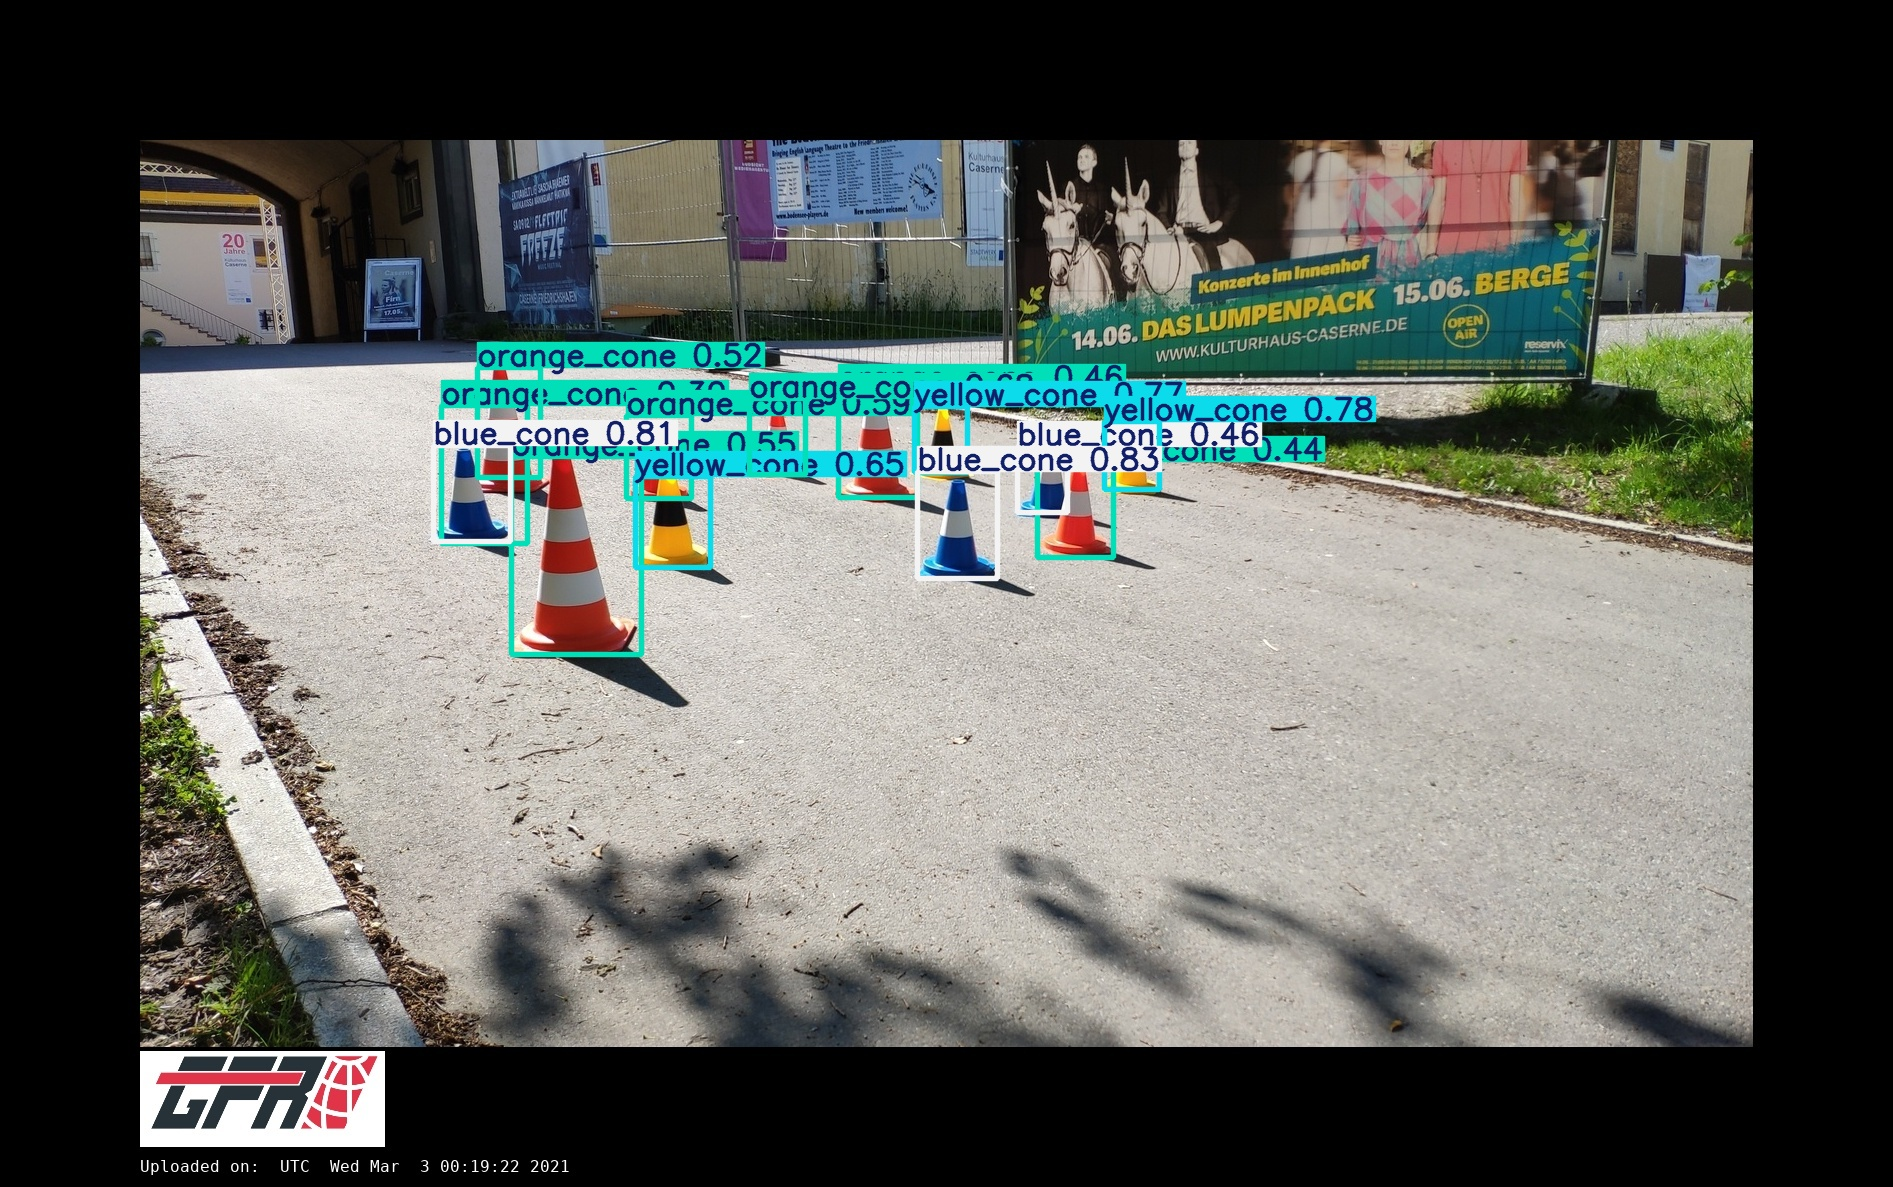

In [12]:
# Get trained weights
if runs:
    weights = runs[-1] / 'weights' / 'best.pt'
    test_imgs = FSOCO_YOLO / 'images' / 'test'
    
    if weights.exists() and test_imgs.exists():
        print("Running inference...\n")
        
        !python {YOLO_DIR}/detect.py \
            --weights {weights} \
            --source {test_imgs} \
            --img {IMG_SIZE} \
            --conf 0.25 \
            --name fsoco_inference \
            --max-det 100
        
        # Show results
        detect_runs = sorted((YOLO_DIR / 'runs' / 'detect').glob('fsoco_inference*'), 
                           key=lambda x: x.stat().st_mtime)
        if detect_runs:
            print(f"\nResults saved to: {detect_runs[-1]}")
            
            # Display first result
            results = list(detect_runs[-1].glob('*.jpg'))[:1]
            for r in results:
                display(IPImage(filename=str(r), width=800))
    else:
        print("Missing weights or test images")
else:
    print("Train model first")

## Done!

**Your model is trained and ready to use.**

**Quick commands:**
```bash
# Inference on images
python yolov5/detect.py --weights runs/train/fsoco_yolov5s/weights/best.pt --source /path/to/images

# Inference on video
python yolov5/detect.py --weights runs/train/fsoco_yolov5s/weights/best.pt --source video.mp4

# Inference on webcam
python yolov5/detect.py --weights runs/train/fsoco_yolov5s/weights/best.pt --source 0
```